# ---MNIST---

In [34]:
#imports
from random import randint
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [16]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [17]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

5


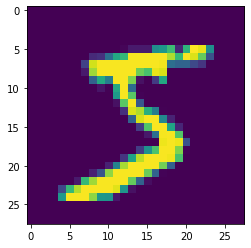

In [18]:
#Get a visual representation of a digit from the dataset
#X represents the numbers that we have as a visual representation in the dataset -> "data"

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image)
#plt.axis("off")
#plt.show()

print(y[0]) # the label says that the shown digit is: 5

In [ ]:
#Split the data for training: - 60000 for the training set
#                             - 10000 for the test set

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [63]:
#Train a binary classifier to see if a digit is 5 or not
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == "5") # True for all 5s, False for all other digits
y_test_5 = (y_test == "5")
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

print(sgd_clf.predict([some_digit])) # -> got [True]

SGDClassifier(random_state=42)

## Measure Performance

### Cross-Validation
- K-fold cross-validation means splitting the training set into K folds
- Making predictions and evaluating them on each fold using a model trained on the remaining folds

In [67]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

# We use StratifiedKFold for stratified sampling
# At each step we train a clone and predict the results
# 3 folds for this example

for i_train, i_test in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[i_train]
    y_train_folds = y_train_5[i_train]
    X_test_fold = X_train[i_test]
    y_test_fold = y_train_5[i_test]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
# -> 0.95035
# -> 0.96035
# -> 0.9604


C:\Users\Viniele\anaconda3\envs\House_price\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [68]:
from sklearn.model_selection import cross_val_score
# we can also use the cross_val_score function to do that, also with 3 folds

print(cross_val_score(sgd_clf, X_train,y_train_5, cv = 3, scoring = "accuracy")) # -> 0.95035 0.96035 0.9604

[0.95035 0.96035 0.9604 ]


### Confusion Matrix
- Count the number of times instances of class A are classified as class B
- We need to have a set of predictions so that they can be compared to the actual targets

In [70]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# to get the predictions set we use cross_val_predict function

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(confusion_matrix(y_train_5, y_train_pred))
# [[53892   687]   ->  [[true-negatives, false-positives]
# [ 1891  3530]]   ->  [false-negatives, true-positive]]


[[53763   816]
 [ 1372  4049]]


### Precision and Recall
- Best used for very precise testing

In [74]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

# F1 score is the harmonic mean
# computing F1 from formula
print(2/(1/precision + 1/recall))

# computing F1 using f1_score() function
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7872836865642621


0.7872836865642621

### Precision/Recall Trade-off


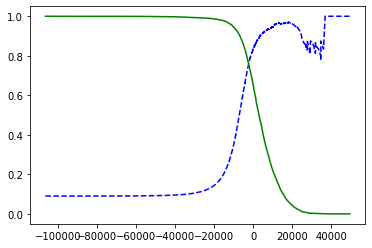

In [75]:
# we need to set a threshold and use the cross_val_predict() fct to do so
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()